# RESULTS


### Scoring metrics used for model analysis

In classification problems, we can distinguish between the following metrics, whereby **the positive class is Charge Off** and **the negative class is Fully Paid**:

- **Recall or Sensitivity or TPR (True Positive Rate)**: Number of loans correctly identified as positive (fully paid) out of total true positives - TP/(TP+FN)
    
- **Specificity or TNR (True Negative Rate)**: Number of loans correctly identified as negative (charged-off) out of total negatives - TN/(TN+FP)

- **Precision**: Number of loans correctly identified as positive (fully paid) out of total items identified as positive - TP/(TP+FP)
    
- **False Positive Rate or Type I Error**: Number of loans wrongly identified as positive (fully paid) out of total true negatives - FP/(FP+TN)
    
- **False Negative Rate or Type II Error**: Number of loans wrongly identified as negative (charged-off) out of total true positives - FN/(FN+TP)

- A **Confusion Matrix**: visual representation of the number of TP, TN, FP and FN.

- **Accuracy**: Percentage of total items classified correctly - (TP+TN)/(N+P)

- **F1 Score**: Harmonic mean of precision and recall given by - F1 = 2xPrecisionxRecall /(Precision + Recall)

- **ROC-AUC Score**: Area under curve of sensitivity (TPR) vs. specificity (TNR).

- **Log-loss**: Probabilistic confidence of accuracy. High value of log-loss means that the absolute probabilities have big difference from actual labels.  

**Scoring in investment strategy**

Insights from [8] were used in this section.

If we choose an investment strategy that uses absolute probabilistic difference, then we will  look at log-loss with care. If the final class prediction is the most important outcome and we don’t want to tune probability threshold, we will rather use AUC score. But if the threshold is well tuned, then F1 will be the scoring to use.

In loan classification, where positive labels (charged-offs) are few, we would like our model to predict positive classes correctly and hence we will sometime prefer those models which are able to classify these positive labels. Log-loss usually fails to identify model which produces too many false negatives because the log-loss function is symmetric and does not differentiate between classes.  Both F1 score and ROC-AUC score can perform well for class imbalance. F1 is better suit for situations where the negative class is small. Since an investor would care more about the minority class (charged-off loans) in number independent of the fact whether it is positive or negative, then **we think that ROC-AUC score would make sense as benchmark measure.**

**Below is the output of the simple model, Logistic Regression and our final model, Random Forest Classifier**

Our base model and final model is Random forest classifier.

However, we did a comparison between the simple logistic regression model and our complex random forest model.
There is a **20.11% increase with area under ROC curve metric, 18.28% increase in CV accuracy metric and 14.48% increase in F1 score**

## Logistic Regression
We will start with a simple logistic regression model for predicting loan charge-off. The penalty parameter is found via cross-validation on the training set.

In [199]:
log_reg = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=5
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=10
    )

In [334]:
dump(log_reg, 'log_reg.joblib') 

['log_reg.joblib']

LogisticRegressionCV:


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1920: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


Accuracy score on training set is 73.43%
K-fold cross-validation results on validation set:
 average accuracy is 67.48%
 average F1 is 67.80%
 average roc_auc is 73.52%


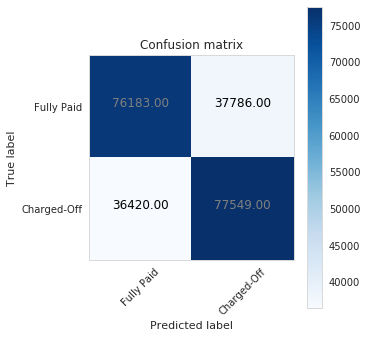

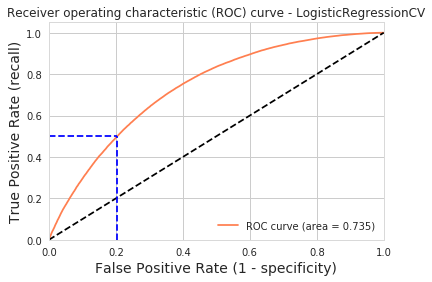

Using a threshold of 0.595 guarantees a sensitivity of 0.500 and a specificity of 0.796, i.e. a false positive rate of 20.40%.


In [200]:
log_reg = fit_predict_evaluate(log_reg, X_train_scaled, y_train, X_val_scaled, y_val, df_cv_scores)

**Logistic Regression with PCA**

LogisticRegressionCV:


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1920: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


Accuracy score on training set is 72.87%
K-fold cross-validation results on validation set:
 average accuracy is 66.99%
 average F1 is 67.57%
 average roc_auc is 72.91%


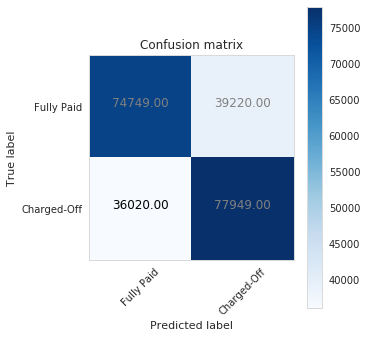

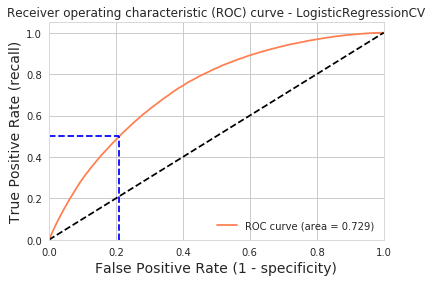

Using a threshold of 0.592 guarantees a sensitivity of 0.500 and a specificity of 0.790, i.e. a false positive rate of 21.04%.


In [204]:
log_reg_pca = fit_predict_evaluate(log_reg, X_train_scaled_pca, y_train, X_val_scaled_pca, y_val, df_cv_scores_pca)


In [333]:
dump(log_reg_pca, 'log_reg_pca.joblib') 

['log_reg_pca.joblib']

PCA causes a decrease in average AUC.

## Random Forest

We will now rebuilt our random forest classifier, this time using the important features.

In [205]:
randomf_optim = RandomForestClassifier(n_estimators=200, max_depth=20)

RandomForestClassifier:
Accuracy score on training set is 91.31%
K-fold cross-validation results on validation set:
 average accuracy is 85.76%
 average F1 is 82.28%
 average roc_auc is 93.63%


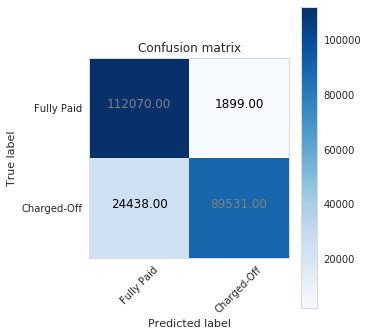

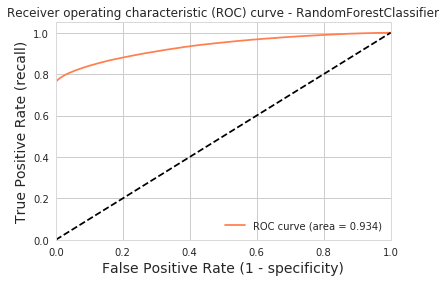

Using a threshold of 0.958 guarantees a sensitivity of 0.500 and a specificity of 1.000, i.e. a false positive rate of 0.00%.


In [206]:
randomf_optim = fit_predict_evaluate(randomf_optim, X_train, y_train, X_val, y_val, df_cv_scores)

The random forest classifier gives the best accuracy so far.

## Model Selection

### Scoring benchmark

We ran these different models using a 10% dataset for computational constraints.

All models investigated in this project are compared in the table below. The performance was evaluated in a out-of-sample manner on the validation set using 3-folds cross-validation.

For each model, we can compare different metrics (accuracy, F1, ROC_AUC). We are also able to compare models using the metric ROC_AUC, which reflect their performance when we set probability cutoff at 50%. 

The scoring results is summarised below.

In [180]:
df_cv_scores_report = df_cv_scores.copy()
df_cv_scores_report.drop('model', inplace=True, errors='ignore')
df_cv_scores_report.sort_values(by=['roc_auc'], ascending=False, inplace=True)
df_cv_scores_report.reset_index(inplace=True)
df_cv_scores_report.rename(columns={'index':'model'}, inplace=True)
df_cv_scores_report

,model,accuracy,f1,roc_auc
0,LogisticRegressionCV,0.814081,0.140528,0.718067
1,XGBClassifier,0.814651,0.172079,0.708668
2,RandomForestClassifier,0.814651,0.109427,0.701997
3,MLPClassifier,0.807098,0.194673,0.697601
4,QuadraticDiscriminantAnalysis,0.705408,0.404361,0.686231
5,AdaBoostClassifier,0.794983,0.199361,0.593578
6,KNeighborsClassifier,0.776099,0.221917,0.591469
7,DecisionTreeClassifier,0.711751,0.267800,0.549992
8,MultinomialNB,0.815578,0.898214,0.537733


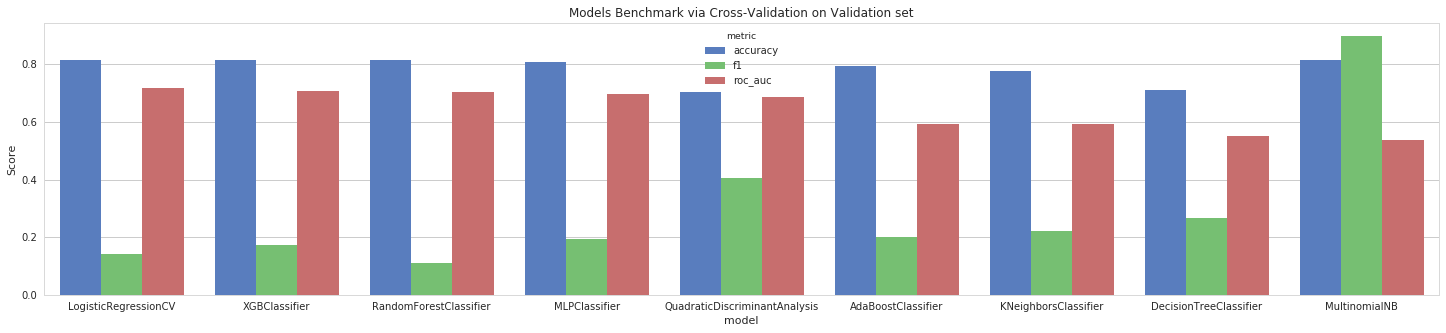

In [181]:
df_cv_scores_melt = pd.melt(df_cv_scores_report, id_vars=['model'], var_name='metric', value_name='score')
fig, ax = plt.subplots(1,1,figsize=(25,5))
sns.set(style="whitegrid")
sns.barplot(x="model", y="score", hue="metric", data=df_cv_scores_melt, palette="muted", ax=ax)
ax.set_title("Models Benchmark via Cross-Validation on Validation set")
ax.set_ylabel("Score");

Some models were also evaluated on a scaled version of the data (with features standardized with zero mean and standard deviation 1). The results below show that standardizing the data did not improve the prediction accuracy.

# Final Model

### Random Forest Classifier is the best performer with area under ROC of 93.63%

**Threshold tuning**

It is more flexible to predict probabilities of a loan belonging to each class rather than predicting classes directly. Probabilities may be interpreted using different thresholds that allow us to trade-off concerns in the errors made by the model, such as the number of false negatives which outweighs the cost of false positives. We will use ROC Curves and Precision-Recall curves as diagnostic tools.

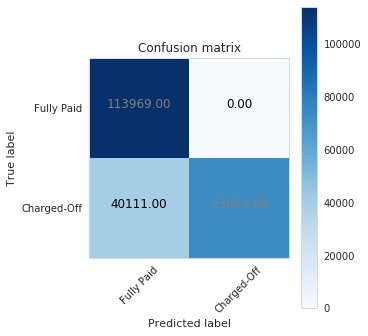

In [221]:
predict_evaluate_cm(randomf_optim, X_val, y_val, threshold=.9)

As shown above if we set the threshold too high, we end up with a very bad prediction of Charge Offs. Although we predict all Fully Paid loans right, our investor will have to deal with a very high number of loans failures.

Below, by choosing a lower threshold the investor will miss some business opportunities, but will secure his finance by correctly identifying those loans with high risk of failures.

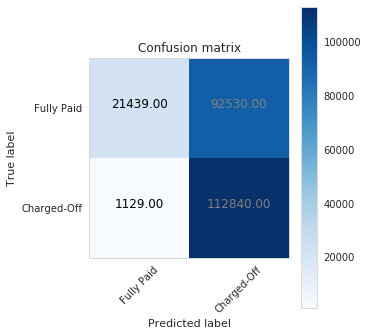

In [222]:
predict_evaluate_cm(randomf_optim, X_val, y_val, threshold=.1)

By choosing a **threshold of 0.3**, we have ca. 7% of false positives. These are loans which have charged off but our model failed to identify them. We will assume that such a threshold is an acceptable compromise for our investment strategy. 

In [223]:
threshold = .3

In [226]:
X_val.shape

(227938, 92)

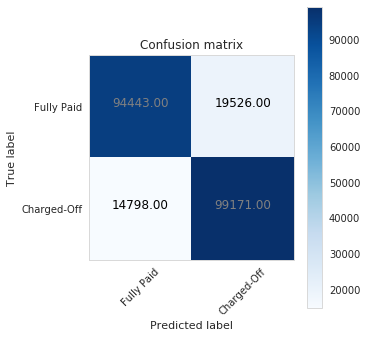

In [225]:
predict_evaluate_cm(randomf_optim, X_val, y_val, threshold=threshold)

# Investment Strategy

## Motivation

Accuracy, ROC, MSE, are terms familiar to a data scientist but, probably not terms an investor would easilly understand. One of the most common metrics to evaluate an investment is Return On Investment (ROI) which can be defined as (FinalValue - InitialValue)/InitialValue. For example, we invest \\$1000 and after a year, our investment is worth \$1200, then our annual ROI is 20%.

We will test our strategy using the 2015 LC loan stats data. 15.68% of the loans in the dataset are classified as False (failed).<br><br>
The goal is to select loans such that the failure rate is less than 15.68%. At this point we are assumung that a selection of loans from the same grade (same interest rate) with a failure rate lower than 15.68% will yield a better ROI for the investor. This needs to be verified and involves looking at the costs of failed loans.<br><br>
The Random Forest model that was developed in the previous section is used here since it clearly outperformed many different models we have been trying based on the ROC_AUC metric. <br><br>
A failure rate of 15.68% or more which sounds excellent, but is indeed no better than a random loan selection.<br><br>
Our Business Objective is to minimize the percentage of Loans selected which are False. This is referred to as the "False Discovery Rate" (FDR). It is equal to 1 - PPV (Positive Prediction Value) [13]. We may reject many loans which are good loans; however, we do not want to select loans that are bad ones.<br><br>

As we saw in the confusion matrix in the previous sections, let's think about what happens when we reduce the threshold from, 50% to 30%. In this case, some loans which would have normally be classified as Fully Paid will be classified as Charge Off. However, the loans that are selected have a higher probability of truly being Charge Off (actual value). Similarly the probability of a selected loan failing will drop. Hence decreasing the threshold increases the quality of the selection with the trade-off that we are throwing away (not selecting) loans which would normally be classified as Good. 

In the next sections we will evaluate this strategy in loans of the same subgrade, as assigned by the LendingClub.

## Prediction

Now it is time to evaluate our model on the left-out data set, which has not been used neither for training nor for cross-validation.

In [346]:
y_test_pred = randomf_optim.predict_proba(X_test)[:, 1]
y_test_pred = adjust_proba(y_test_pred, threshold)
test_score = accuracy_score(y_test, y_test_pred)
print("With probability threshold {0}, the Classification Accuracy Score on Test is {1:.2%}".format(threshold, test_score))

With probability threshold 0.3, the Classification Accuracy Score on Test is 75.57%


These are compeling results showing that the model separates fully paid from charge-off loans with high accuracy on unseen data.

In [214]:
print("Without our model, randomly picking a successful loan would be with {0:.2%} chances.".format(len(y_test[y_test==0])/len(y_test)))

Without our model, randomly picking a successful loan would be with 81.18% chances.


## Evaluation

The function below fits a predictive model with a subset of data depending on the invesment strategy (sub grades and term), and it displays the accuracy of our predictions, as well as an estimation of the Return Of Investment campared to the default strategy offered by LendingClub.

In [294]:
def simulate_strategy(df, X_test_df, X_test, sub_grades=['A1'], terms=[36], threshold=.3, verbose=True):
    # indexes of test loans in the original data frame containing all loans
    test_idx = X_test_df.index.values
    # test loans from the original data frame containing all loans
    df_test = df.loc[test_idx]
    # subset of candidate test loans, filtered by specific sub grades and terms
    df_test_candidates = df_test[(df_test.sub_grade.isin(sub_grades)) & (df_test.term.isin(terms))]
    if df_test_candidates.shape[0] == 0:
        return 0, 0
    # indexes of candidate test loans
    df_test_candidates_idx = df_test_candidates.index.values
    # candidate test loans in the design matrix
    X_test_candidates = X_test[df_test.index.isin(df_test_candidates_idx)]
    y_test_candidates = y_test[df_test.index.isin(df_test_candidates_idx)]
    # prediction of loan status for candidate test loans
    y_test_candidates_pred_orig = randomf_optim.predict_proba(X_test_candidates)[:, 1]
    y_test_candidates_pred = adjust_proba(y_test_candidates_pred_orig, threshold)
    test_score = accuracy_score(y_test_candidates, y_test_candidates_pred)
    df_test_candidates = df_test_candidates.assign(loan_status_predicted = y_test_candidates_pred)
    # calculate the ROI for each candidate test loan
    df_test_candidates['roi'] = df_test_candidates.apply(calc_roi, axis=1)
    # calculate average annual ROI for the Lender's CLub 'Automatic' selection
    roi_lc = df_test_candidates['roi'].mean()
    # calculate average annual ROI for loans which our model predicts they will be fully paid (prediction is 0)
    roi_randomf = df_test_candidates[df_test_candidates.loan_status_predicted==0]['roi'].mean()
    # display results
    if verbose:
        print('Investment on sub grades {} and terms {}:'.format(sub_grades, terms))
        print('')
        print("  With probability threshold {0}, the selected loans were classified with accuracy {1:.2%}".format(threshold, test_score))
        print("  Average annual ROI for Lending Club is {}%".format(round(roi_lc,2)))
        print("  Average annual ROI for our model is {}%".format(round(roi_randomf,2)))
    return [roi_lc, roi_randomf, df_test_candidates]

In [216]:
#
# Calculate ROI. Monthly data and much better documentation from Lender's Club is needed
# to precisely calculate ROI. Still, this is not bad!
#
def calc_roi(row):
# We assume here that  charge-offs are made in the last month
    def insuf_payment(factor, i):

        loss = int_rcvd + pmt_rcvd + net_recoveries +late_fees - owed
        factor *= (1 + loss/principal)
        factor = factor**(1/term)
        return factor**12 - 1
    
    def early_payoff(factor, i):
        return (factor**(1/(i+1)))**12 - 1 
        
    term = row.term
    int_rcvd = row.total_rec_int
    pmt_rcvd = row.total_pymnt
    principal = row.funded_amnt
    yr_int_rate = row.int_rate
    mo_int_rate = (1+yr_int_rate)**(1/12) - 1
    mo_pay = row.installment
    
    recoveries = row.recoveries
    late_fees = row.total_rec_late_fee
    fee = row.collection_recovery_fee
    
    net_recoveries = recoveries - fee
    
    owed = principal

# Calculate monthly gain (could be less than 1) while there are months to go and interest
# Could be extra interest because of hardship plans
    factor = 1

#---Beginning of For------------------------
    for i in range(0, int(term)):

        if (pmt_rcvd + .50 < mo_pay):
             return insuf_payment(factor, i)
        this_interest = owed*mo_int_rate     
        
# If not enough interest was paid to cover this month, consider loan paid off early
# and count monthly gain as (1+mo_int_rate), just like NAR

        factor *= 1 + mo_int_rate

        if (this_interest > int_rcvd):
            return early_payoff(factor, i)
            
        int_rcvd -= this_interest
        if owed < mo_pay:
            return early_payoff(factor, i)
        pmt_rcvd -= mo_pay
        owed -= mo_pay - this_interest
#---End of For-------------------------------
    return early_payoff(factor, i)

We can simulate an improved return of investment on specific loans types below.

In [392]:
[roi_lc, roi_df, df_test_candidates] = simulate_strategy(df_loan_accepted_census_cleaned, 
                                                               X_test_df, X_test, 
                                                               sub_grades=['A1','A2','A3','A4', 'A5'], 
                                                               terms=[36], 
                                                               threshold=.3)

Investment on sub grades ['A1', 'A2', 'A3', 'A4', 'A5'] and terms [36]:

  With probability threshold 0.3, the selected loans were classified with accuracy 94.18%
  Average annual ROI for Lending Club is 7.25%
  Average annual ROI for our model is 7.25%


We can also simulate the model on all sorts of subgrades/terms combinations.

In [362]:
sub_grades = df_loan_accepted_census_cleaned.sub_grade.unique()
terms = df_loan_accepted_census_cleaned.term.unique()
df_roi = pd.DataFrame(columns=['sub_grad', 'term', 'threshold', 'strategy', 'roi'])
df_roi_grp = pd.DataFrame(columns=['sub_grad', 'term', 'threshold', 'lc_roi', 'cs109a_roi'])
i = 0
j = 0
for sub_grade in sub_grades:
    for term in terms:
        for t in [0.1, 0.3, 0.5, 0.7, 0.9]:
            r = simulate_strategy(df_loan_accepted_census_cleaned, 
                                               X_test_df, X_test, 
                                               sub_grades=[sub_grade], 
                                               terms=[term], 
                                               threshold=t,
                                               verbose=False)
            df_roi.loc[i]=[sub_grade, term, t, 'LendingClub', r[0]]         
            df_roi.loc[i+1]=[sub_grade, term, t, 'CS109a', r[1]]         
            df_roi_grp.loc[j]=[sub_grade, term, t, r[0], r[1]]         
            i += 2
            j += 1

The average return of investment by the LendingClub strategy compared to our strategy is given below. We can observe a very high similarity.

In [375]:
df_roi_grp.groupby(['sub_grad', 'term']).mean()[['lc_roi', 'cs109a_roi']]

lc_roi  cs109a_roi
sub_grad term                       
A1       36     5.738038    5.739396
         60     0.000000    0.000000
A2       36     6.426271    6.427185
         60     0.000000    0.000000
A3       36     7.156332    7.160028
         60     6.816667    6.816667
A4       36     7.553514    7.557870
         60     7.411053    7.431553
A5       36     8.306587    8.311984
         60     8.282982    8.326529
B1       36     9.020524    9.033578
         60     8.834566    8.852310
B2       36    10.083454   10.108652
         60     9.897557    9.961292
B3       36    11.033064   11.050416
         60    10.744705   10.828844
B4       36    11.867929   11.869740
         60    11.590650   11.635116
B5       36    12.369352   12.383520
         60    12.126805   11.950350
C1       36    12.990386   12.915527
         60    12.845539   12.868356
C2       36    13.472143   13.472411
         60    13.588558   13.602550
C3       36    14.050165   14.051155
         60    14.214597   14.228932
C4       36    14.622170   14.625210
         60    14.730808   14.760422
C5       36    15.275164   15.276841
         60    15.595178   15.634359
...                  ...         ...
E1       36    18.942236   18.965256
         60    18.875294   18.863097
E2       36    19.647977   19.662342
         60    19.438445   19.403086
E3       36    19.986914   19.985403
         60    20.035647   19.790796
E4       36    20.837799   20.864478
         60    20.934504   20.705130
E5       36    21.957874   21.836988
         60    21.664648   21.084499
F1       36    22.875969   22.868785
         60    22.477824   22.023522
F2       36    23.271900   23.104366
         60    23.287595   22.664847
F3       36    23.719627   23.647012
         60    23.978175   23.920056
F4       36    24.299783   24.380774
         60    24.636327   24.587525
F5       36    24.466667   24.124000
         60    25.096503   25.029638
G1       36    25.644074   25.594056
         60    25.491631   25.399722
G2       36    25.908333   25.866250
         60    25.722389   25.046562
G3       36    26.885000   26.885000
         60    25.957838   25.815077
G4       36    25.690000   25.456667
         60    26.205294   25.504147
G5       36     0.000000    0.000000
         60    25.983000   25.672034

[70 rows x 2 columns]

# Plots to check our model on fairness and discrimination

**The output of our model is the dataframe "df_test_candidates", selected loans by our model. We will use this information to our model for fairness and discrimination**

**Plot 1**

In [376]:
df_test_picked = df_test_candidates[df_test_candidates.loan_status_predicted==0]

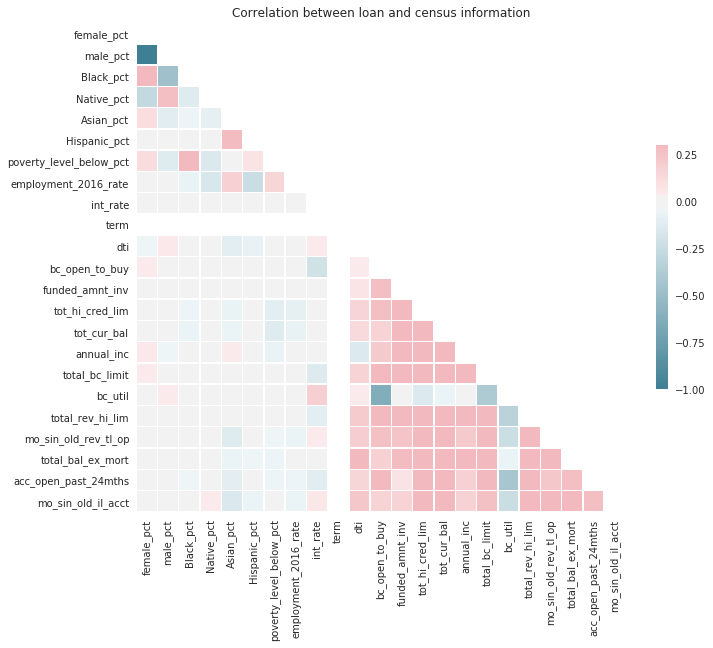

In [378]:
cols1 = ['loan_status','female_pct','male_pct','Black_pct','Native_pct','Asian_pct','Hispanic_pct','poverty_level_below_pct','employment_2016_rate']
cols2 = ['int_rate','term','dti','bc_open_to_buy','funded_amnt_inv','tot_hi_cred_lim','tot_cur_bal','annual_inc','total_bc_limit','bc_util','total_rev_hi_lim','mo_sin_old_rev_tl_op','total_bal_ex_mort','acc_open_past_24mths','mo_sin_old_il_acct']
corr = df_test_picked[cols1 + cols2].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation between loan and census information');

We are particularly interested in the correlation between census features and loan features (see the area marked with a rectangle with black borders). The correlation is very low to almost not existent.

**Plot 2**

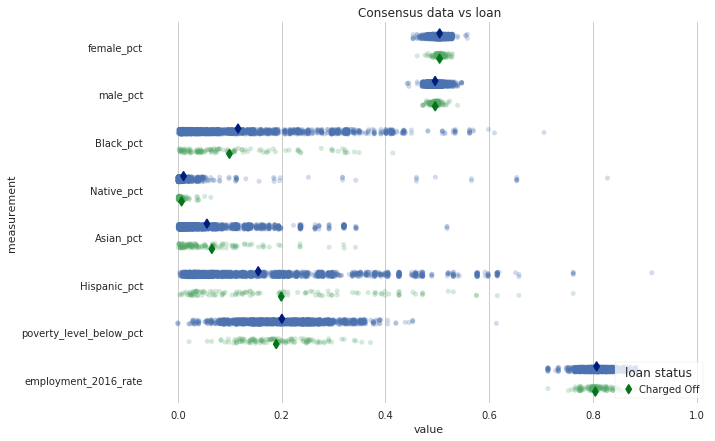

In [379]:
df = pd.melt(df_test_picked[['loan_status','female_pct','male_pct','Black_pct','Native_pct','Asian_pct','Hispanic_pct','poverty_level_below_pct','employment_2016_rate']], "loan_status", var_name="measurement")
df.head()

f, ax = plt.subplots(figsize=(10,7))
sns.despine(bottom=True, left=True)
sns.stripplot(x="value", y="measurement", hue="loan_status",
              data=df, dodge=True, jitter=True, alpha=.25,zorder=1)
sns.pointplot(x="value", y="measurement", hue="loan_status",
              data=df, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="loan status",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)
ax.set_title('Consensus data vs loan');

We investigate fairness by displaying a stripplot with the distribution of census data.
Overall it seems the likelihood of failing to fully payback loans is not affected by the race and gender.
The distribution of paid and unpaid loans is very similar among groups of borrowers with different
race or gender. Surprisingly being English speaker or living in a zone with poverty level below
national average is not impacting the ratio of charged-off to fully payment. We think that this is
because the data at hand obtained from the Lending Club does not disclose the full zip code for a
closer match to census data.

## Algorithmic Fairness

A high level goal of this project is addressing the ethic implications of our model along the lines of fairness and discrimination.

It is a known fact that algorithms can facilitate illegal discrimination. 

An investor wants to invest in loans with high return of investment and low risk. A modern idea is to use an algorithm to decide, based on the sliver of known information about the outcome of past loans, which future loan requests give the largest chance of the borrower fully paying it back, while achieving the best trade-off with high returns (high interest rate). Our model is such an algorithm.

There’s one problem: our model is trained on historical data, and poor uneducated people, often racial minorities or people with less working experience have a historical trend of being more likely to succumb to loan charge-off than the general population. So if our model is trying to maximize return of investment, it may also be targeting white people, people on specific zip codes, people with work experience, de facto denying opportunities for fair loans to the remaining population.

Such behavior would be illegal [15].

There could be two points of failure here: 

- we could have unwittingly encode biases into the algorithm based on a biased exploration of the data
- the data itself could encode biases due to human decisions made to create it

Although there is no definition which is widely agreed as a good definition of fairness, we will use **statistical parity** to test hypothesis of fairness on our model.

Given a sub grade and a term, assuming that the population of borrowers who applied for a loan of that term and were assigned the sub grade is called $P$, and there is a known subset $F$ of female borrowers within that population. We assume that there is some distribution $D$ over $P$ which represents the probability that any of those borrowers will be picked by our model for evaluation. Our model is a classifier $m: X \rightarrow \{0, 1\}$ that gives labels borrowers. if $m=1$ then the person will Charge Off on his loan, if $m=0$, he will fully pay his loan. The bias or **statistical imparity** of $m$ on $F$ with respect to $X, D$ is the difference between the probability that a random female borrower is labeled 1 and the probability that a random male borrower is labeled 1. If that difference is small, then we can say that our model is having statistical parity [17].


The function below measures the statistical parity of our model on protected population $F$. This metric describes how fair our model is with respect to the protected subset population. The input of the function is an array of binary values (1 if the sample is a loan requested by a female, 0 else) and a second array of binary values (1 if the model predicted that the loan will Charge Off, 0 else).  The code is adapted from [16].

In [380]:
def statistical_parity(protected_status, loan_status_predicted):

    if len(protected_status) != len(loan_status_predicted):
        raise ValueError('Input arrays do not have same number of entries')

    indices_pos_class, = np.where(protected_status == 1)
    indices_neg_class, = np.where(protected_status == 0)

    outcomes_pos = loan_status_predicted[indices_pos_class]
    outcomes_neg = loan_status_predicted[indices_neg_class]

    if len(outcomes_pos) == 0:
        return None
    if len(outcomes_neg) == 0:
        return None
    value_discrim = np.abs(len(np.where(outcomes_pos == 1)) /
                           len(outcomes_pos) -
                           len(np.where(outcomes_neg == 1)) /
                           len(outcomes_neg))

    return value_discrim


The function below test statistical parity on a group of features of the borrowers.

In [381]:
def model_fairness_check(df, protected_groups, fairness_threshold):
    for group in protected_groups:
        protected_status = df_test_candidates[group].apply(lambda x: 1 if x>0.5 else 0)
        loan_status_predicted = df_test_candidates['loan_status_predicted'].values
        stats_parity = statistical_parity(protected_status, loan_status_predicted)
        if stats_parity == None:
            print("Not enough data available for {}".format(group))
        else:
            if abs(stats_parity) < fairness_threshold:
                print("The model is FAIR on {} with statistical parity {}".format(group, round(stats_parity,5)))
            else:
                print("The model is NOT FAIR on {} with statistical parity {}".format(group, round(stats_parity,5)))

Now we can test the fairness of our model with regard to specifics borrowers.

In [382]:
model_fairness_check(df_test_candidates, ['female_pct','Black_pct', 'Native_pct', 'Asian_pct','Hispanic_pct', 'household_family_pct', 'poverty_level_below_pct','Graduate_Degree_pct'], fairness_threshold=.01)

The model is FAIR on female_pct with statistical parity 0.00016
The model is FAIR on Black_pct with statistical parity 0.00817
The model is NOT FAIR on Native_pct with statistical parity 0.0499
The model is NOT FAIR on Asian_pct with statistical parity 0.0399
The model is FAIR on Hispanic_pct with statistical parity 0.00248
The model is FAIR on household_family_pct with statistical parity 0.00227
The model is NOT FAIR on poverty_level_below_pct with statistical parity 0.2499
Not enough data available for Graduate_Degree_pct


**Disparate impact** in United States labor law refers to "practices in employment, housing, and other areas that adversely affect one group of people of a protected characteristic more than another, even though rules applied by employers or landlords are formally neutral."[18]. It measures the difference that the majority and protected classes get a particular outcome. We use the function below adapted from [16] to check on disparate impact based on the legal definition of threshold of 80%. This is determined with respect to a protected class.

The input of the function is an array of binary values (1 if the sample is a loan requested by a female, 0 else) and a second array of binary values (1 if the model predicted that the loan will Charge Off, 0 else). If $\dfrac{P(male | chargeoff )}{P(female | chargeoff )} \leq 80%$ then the definition of disparate impact is satisfied. The output is True is the model demonstrates discrimination, False else. The degree of discrimation is also provided between 0 and 1.

In [383]:
def disparate_impact(protected_status, loan_status_predicted):
    if len(protected_status) != len(loan_status_predicted):
        raise ValueError('Input arrays do not have same number of entries')

    # "positive class" are those where predictions = Charge Off
    # "majority class" are those where protected class status = 1
    
    indices_pos_class, = np.where(protected_status == 1)
    
    outcomes_pos = loan_status_predicted[indices_pos_class]

    if len(np.where(outcomes_pos == 1)) == 0:
        return None, None
    
    value_discrim = len(np.where(outcomes_pos == 0)) / len(
        np.where(outcomes_pos == 1))

    if value_discrim <= 0.8:
        is_discriminatory = True
    else:
        is_discriminatory = False

    return is_discriminatory, 1 - value_discrim

The function below disparate impact on a group of features of the borrowers.

In [384]:
def model_disparate_impact_check(df, protected_groups):
    for group in protected_groups:
        protected_status = df_test_candidates[group].apply(lambda x: 1 if x>0.5 else 0)
        loan_status_predicted = df_test_candidates['loan_status_predicted'].values
        discriminate, level_discrimination = disparate_impact(protected_status, loan_status_predicted)
        if discriminate == None:
            print("Not enough data available for {}".format(group))
        else:
            if discriminate:
                print("The model is DISCRIMINATING on {} with level {}".format(group, round(level_discrimination,5)))
            else:
                print("The model is NOT DISCRIMINATING on {}".format(group))

Now we can test the disparate impact of our model with regard to specific borrowers.

In [385]:
model_disparate_impact_check(df_test_candidates, ['female_pct','Black_pct', 'Native_pct', 'Asian_pct','Hispanic_pct', 'household_family_pct', 'poverty_level_below_pct','Graduate_Degree_pct'])

The model is NOT DISCRIMINATING on female_pct
The model is NOT DISCRIMINATING on Black_pct
The model is NOT DISCRIMINATING on Native_pct
The model is NOT DISCRIMINATING on Asian_pct
The model is NOT DISCRIMINATING on Hispanic_pct
The model is NOT DISCRIMINATING on household_family_pct
The model is NOT DISCRIMINATING on poverty_level_below_pct
The model is NOT DISCRIMINATING on Graduate_Degree_pct
